In [39]:
import logging
from dataclasses import dataclass

import mne
import re
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
from mne.utils import set_log_file
from sklearn.decomposition import PCA
import numpy as np
from ssqueezepy import Wavelet, cwt, icwt
from lifelines import KaplanMeierFitter
from ssqueezepy.experimental import scale_to_freq
from sklearn.linear_model import LinearRegression
import pandas as pd
import os
import json

# matplotlib.use('Qt5Agg')
# plt.switch_backend('QtAgg')

Constants

In [43]:
random_state = 42

GNG: 
- A-GNG-050 - zapis zaczπ≥ siÍ zbyt pÛüno, plik w Full Recode ma usuniÍte poczπtkowe triggery, makro no_check_iterator na poczπtku drzewka
- B-GNG-128 - brakuje prawie ca≥ego treningu, plik w Full Recode ma usuniÍte poczπtkowe triggery, makro no_check_iterator na poczπtku drzewka

- B-GNG-069 - dodatkowy trigger (9) na pozycji 359804, node Edit Markers na poczπtku drzewka
- B-GNG-102 - dodatkowy trigger (15) na pozycji 328219, node Edit Markers na poczπtku drzewka

- B-GNG-005 - sygna≥ zreferowany wy≥πcznie do A1, poniewaø A2 jest zbyt zaszumiona

Exclude:
- B-GNG-086 - 117 GO trials without reaction; no trials with good feedback (fast responses); 13 uninhibited NoGo trials;
- B-GNG-075: no EEG recording;


Loggers

In [41]:
######## PREPROCESSING ##############################################
# Create a custom logger for preprocessing INFO
logger_preprocessing_info = logging.getLogger('preprocessing_info')
logger_preprocessing_info.setLevel(logging.INFO)
# 
# # Create a file handler for preprocessing and set the level to INFO
# file_handler_preprocessing = logging.FileHandler('data/preprocessing.txt')
# file_handler_preprocessing.setLevel(logging.INFO)
# 
# # Create a formatter and add it to the file handler for preprocessing
# formatter_preprocessing = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
# file_handler_preprocessing.setFormatter(formatter_preprocessing)
# 
# # Add the file handler for method A to the logger for preprocessing
# logger_preprocessing_info.addHandler(file_handler_preprocessing)

######## ERRORS ##############################################
# Create a custom logger for errors
logger_errors_info = logging.getLogger('errors')
logger_errors_info.setLevel(logging.INFO)
# 
# # Create a file handler for errors and set the level to INFO
# file_handler_errors = logging.FileHandler('data/errors.txt')
# file_handler_errors.setLevel(logging.INFO)
# 
# # Create a formatter and add it to the file handler for errors
# formatter_errors = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
# file_handler_errors.setFormatter(formatter_errors)

# Add the file handler for method A to the logger for preprocessing
# logger_errors_info.addHandler(file_handler_errors)

In [47]:
def read_trigger_map(file_name):
    line_count = 0
    trigger_map = []
    with open(file_name, 'r') as file:
        # Read each line and increment the counter
        line = file.readline()
        try:
            match = re.search("(.*):(.*)(\\n)", line)
            trigger = (match.group(1), match.group(2), )
            trigger_map.append(trigger)
        except:
            pass
        while line:
            line_count += 1
            line = file.readline()
            try:
                match = re.search("(.*):(.*)(\\n)", line)
                trigger = (match.group(1), match.group(2), )
                trigger_map.append(trigger)
            except:
                pass

    assert len(trigger_map) == line_count, \
        f'The length of trigger file ({line_count}) not equals length of created trigger_map ({len(trigger_map)})'

    return trigger_map

def create_triggers_dict(trigger_map):
    triggers_codes = [item[1] for item in trigger_map]
    # Create an ordered dictionary to maintain order and remove duplicates
    unique_ordered_dict = OrderedDict.fromkeys(triggers_codes)
    numbered_dict = {key: 1000 + number for number, key in enumerate(unique_ordered_dict.keys())}
    reversed_numbered_dict = {1000 + number: key for number, key in enumerate(unique_ordered_dict.keys())}
    return numbered_dict, reversed_numbered_dict

def replace_trigger_names(raw, trigger_map, new_response_event_dict=None, replace=False, search='RE'):
    # Replace event IDs in the Raw object
    events = mne.find_events(raw, stim_channel='Status')
    new_events_list = events.copy()
    logger_preprocessing_info.info(f'EVENTS: {new_events_list}')

    assert len(events) == len(trigger_map), \
        f'The length of trigger map ({len(trigger_map)}) not equals length of events in eeg recording ({len(events)})'

    trigger_map_codes, mapping = create_triggers_dict(trigger_map)

    for idx, event in enumerate(events):
        event_id = str(event[2])[-1]
        trigger_id = trigger_map[idx][0]
        trigger_new_code = trigger_map[idx][1]

        if event_id != trigger_id:
            logger_errors_info.info(f'An event {idx} has different number than in provided file. {trigger_id} expected, {str(event[2])} found. Triggers may need to be checked.')

        trigger_new_code_int = trigger_map_codes[trigger_new_code]
        new_events_list[idx][2] = trigger_new_code_int

    annot_from_events = mne.annotations_from_events(
        events=new_events_list,
        event_desc=mapping,
        sfreq=raw.info["sfreq"],
        orig_time=raw.info["meas_date"],
    )
    raw_copy = raw.copy()
    raw_copy.set_annotations(annot_from_events)

    return raw_copy

def find_items_matching_regex(dictionary, regex):
    pattern = re.compile(regex)
    matching_items = {key: value for key, value in dictionary.items() if pattern.match(key)}
    return matching_items

# def create_events_mappings(trigger_map, case='RE'):
#     trigger_map_codes, mapping = create_triggers_dict(trigger_map)
# 
#     event_dict = {}
#     events_mapping = {}
#     new_response_event_dict = {"correct_response": 0, "error_response": 1}
# 
#     if case == 'RE':
#         events_mapping = {
#             'correct_response': [],
#             'error_response': [],
#         }
#         # find response events from experimental blocks
#         regex_pattern = r'RE\*ex\*.*\*num_separator'
#         event_dict = find_items_matching_regex(trigger_map_codes, regex_pattern)
# 
#         for event_id in event_dict.keys():
#             event_id_splitted = event_id.split('*')
# 
#             if (event_id_splitted[2][0] == event_id_splitted[3][0]) and (
#                     event_id_splitted[3][-1] == '1'):
#                 events_mapping['correct_response'].append(event_dict[event_id])
#             else:
#                 events_mapping['error_response'].append(event_dict[event_id])
# 
#     else:
#         print('Not implemented for feedback and stimuli')
# 
#     return event_dict, events_mapping, new_response_event_dict

@dataclass
class ParticipantTriggerMappingContext:
    event_dict: dict
    events_mapping: dict
    new_event_dict: dict

    def __str__(self):
        return f"{self.event_dict}\n{self.events_mapping}\n{self.new_event_dict}"

def create_events_mappings(trigger_map, case='RE') -> ParticipantTriggerMappingContext:
    trigger_map_codes, mapping = create_triggers_dict(trigger_map)

    if case == 'RE':
        new_event_dict = {"correct_response": 0, "error_response": 1}
        events_mapping = {
            'correct_response': [],
            'error_response': [],
        }
        # find response events from experimental blocks
        regex_pattern = [r'RE\*ex\*.*\*num_separator']
        event_dict = find_items_matching_regex(trigger_map_codes, regex_pattern)

        for event_id in event_dict.keys():
            event_id_splitted = event_id.split('*')

            if (event_id_splitted[2][0] == event_id_splitted[3][0]) and (
                    event_id_splitted[3][-1] == '1'):
                events_mapping['correct_response'].append(event_dict[event_id])
            else:
                events_mapping['error_response'].append(event_dict[event_id])

    elif case == 'STIM':
        new_event_dict = {"inhibited_nogo": 0, "uninhibited_nogo": 1, "successful_go": 2}
        events_mapping = {
            'inhibited_nogo': [],
            'uninhibited_nogo': [],
            'successful_go': [],
        }
        # find all NoGo stimuli events from experimental blocks
        no_go_regex_pattern = [
            r'TG\*ex\*1_n\*1_c_2\*.*',
            r'TG\*ex\*1_n\*2_c_1\*.*',
            r'TG\*ex\*2_n\*1_c_1\*.*',
            r'TG\*ex\*2_n\*2_c_2\*.*',
        ]
        no_go_event_dict = find_items_matching_regex(trigger_map_codes, no_go_regex_pattern)

        # find all succesfull Go stimuli events from experimental blocks
        go_regex_pattern = [
            r'TG\*ex\*1_n\*1_c_1\*R',
            r'TG\*ex\*2_n\*2_c_1\*R',
        ]
        go_event_dict = find_items_matching_regex(trigger_map_codes, go_regex_pattern)

        # separate trials with responses (uninhibited) from inhibited ones
        for event_id in no_go_event_dict.keys():
            if event_id[-1] == '-':
                events_mapping['inhibited_nogo'].append(no_go_event_dict[event_id])
            elif event_id[-1] == 'R':
                events_mapping['uninhibited_nogo'].append(no_go_event_dict[event_id])

        for event_id in go_event_dict.keys():
            if event_id[-1] == 'R':
                events_mapping['successful_go'].append(go_event_dict[event_id])

        event_dict = {**no_go_event_dict, **go_event_dict}

    elif case == 'FBCK':
        logger_errors_info.info('Not implemented for feedback and stimuli')
        event_dict = {}
        events_mapping = {}
        new_event_dict = {}
    else:
        logger_errors_info('Not known case. Possible cases: \'RE\' for response, \'STIM\` for stimuli, and \`FBCK\` for feedback-locked events extraction.')
        # todo raise an Error
        event_dict = {}
        events_mapping = {}
        new_event_dict = {}


    return ParticipantTriggerMappingContext(event_dict=event_dict,
                                            events_mapping=events_mapping,
                                            new_event_dict=new_event_dict)

def create_epochs(
    raw,
    context: ParticipantTriggerMappingContext,
    tmin=-.1,
    tmax=.6,
    baseline=None,
    reject=None,
    reject_by_annotation=False,
    detrend=None
):
    # select specific events
    events, event_ids = mne.events_from_annotations(raw, event_id=context.event_dict)

    # Merge different events of one kind
    for mapping in context.events_mapping:
        events = mne.merge_events(
            events=events,
            ids=context.events_mapping[mapping],
            new_id=context.new_event_dict[mapping],
            replace_events=True,
        )
    
    # Read epochs
    epochs = mne.Epochs(
        raw=raw,
        events=events,
        event_id=context.new_event_dict,
        tmin=tmin,
        tmax=tmax,
        baseline=baseline,
        reject_by_annotation=reject_by_annotation,
        preload=True,
        reject=reject,
        picks=['eeg', 'eog'],
        detrend=detrend,
    )
    
    return epochs


def ocular_correction_gratton(epochs, subtract_evoked=False):

    if subtract_evoked:
        epochs_sub = epochs.copy().subtract_evoked()

        eog_model = mne.preprocessing.EOGRegression(
            picks="eeg",
            picks_artifact="eog"
        ).fit(epochs_sub)
    else:
        eog_model = mne.preprocessing.EOGRegression(
            picks="eeg",
            picks_artifact="eog"
        ).fit(epochs)

    epochs_clean_plain = eog_model.apply(epochs)

    return epochs_clean_plain

def find_bad_trials(epochs, picks=['FCz','Cz']):
    """
    """
    # epochs_copy = epochs.copy()
    epochs_picked_channels = epochs.copy().pick(picks=picks)

    epochs_picked_channels.drop_bad()
    drop_log = epochs_picked_channels.drop_log

    for idx, _ in enumerate(epochs_picked_channels):
        epoch = epochs_picked_channels[idx]
        epoch_data = epoch.get_data(copy=True)
        
        for ch_name, ch_idx in zip(epochs_picked_channels.info['ch_names'], 
                                   np.arange(0, len(epochs_picked_channels.info['ch_names']))):
            channel_data = epoch_data[0,ch_idx,:]

            # EEG signal at the FCz or Cz site was greater than ± 150 μV were removed
            if(abs(channel_data) > 150e-6).any():
                logger_preprocessing_info.info(f'Channel {ch_name} exceeded +- 150 μV threshold at {idx} trail')
                new_drop_log_item = drop_log[idx] + (ch_name, ) if ch_name not in drop_log[idx] else drop_log[idx]
                drop_log = tuple(new_drop_log_item if i == idx else item for i, item in enumerate(drop_log))

    del epochs_picked_channels

    return drop_log


def reject_bad_trials(epochs, drop_log, picks=['FCz', 'Cz']):

    epochs_to_drop_indices = []
    clean_epochs = epochs.copy()

    assert len(epochs_copy) == len(drop_log), f'Length of epochs ({len(epochs_copy)}) not equals length of drop_log ({len(drop_log)}). Cannot mark trials as BAD.'
            
    for idx, item in enumerate(drop_log):
        if ('FCz' in item) or ('Cz' in item):
            logger_preprocessing_info.info(f'Rejecting trial {idx}. Artifacts at Fz or FCz')
            epochs_to_drop_indices.append(idx)

    clean_epochs = clean_epochs.drop(
        indices = epochs_to_drop_indices,
        reason = 'EXCEED 150uV',
    )

     # update drop_log
    for trial_idx in epochs_to_drop_indices:
        drop_log = tuple(('REJECTED',) if i == trial_idx else element for i, element in enumerate(drop_log))
    
    return clean_epochs, drop_log    

In [48]:
def pre_process_eeg(input_fname, context, trigger_fname=None, tmin=-0.1, tmax=0.9):
    # 0. read bdf
    raw = mne.io.read_raw_bdf(
        input_fname,
        eog=['EXG1', 'EXG2', 'EXG3', 'EXG4'],
        exclude=['EXG5', 'EXG6'],
        preload=True
    )

    try:
        raw = raw.set_montage('biosemi64')
    except ValueError as e:
        if '[\'EXG7\', \'EXG8\']' in e.args[0]:
            raw = raw.set_montage('biosemi64', on_missing='ignore')
            logger_preprocessing_info.info('On missing')
        else:
            logger_errors_info.info('Lacks important channels!')

    # 1. replace trigger names
    trigger_map = read_trigger_map(trigger_fname)
    raw_new_triggers = replace_trigger_names(raw, trigger_map)

    # 2. re-reference: to mastoids
    raw_ref = raw_new_triggers.copy().set_eeg_reference(ref_channels=['EXG7', 'EXG8'])

    # 3. Resampling
    raw_resampled = raw_ref.copy().resample(sfreq=500)

    # 4. Detrending, Segmentation, and first baseline correction
    epochs = create_epochs(
        # raw_resampled,
        raw_resampled,
        tmin = tmin,
        tmax = tmax,
        baseline = (-0.1, 0),
        detrend = 1,
        context=context,
        reject = None,
        reject_by_annotation = False,
    )

    # 5. ocular artifact correction with Gratton
    epochs_eog_corrected = ocular_correction_gratton(epochs)
    
    # 6. Second re-baseline
    epochs_eog_corrected.apply_baseline()
    
    # 7. Mark bad trials
    drop_log = find_bad_trials(epochs_eog_corrected, picks=['FCz', 'Cz'])

    # 8. Reject bad trials
    # clean_epochs, drop_log = reject_bad_trials(epochs_eog_corrected, drop_log)

    return epochs_eog_corrected, drop_log

In [49]:
def save_epochs_with_drop_log(epochs, drop_log, id):
    item = pd.DataFrame({
        'epochs': [epochs],
        'drop_log': [drop_log],
    })

    item.to_pickle(f'{preprocessed_data_dir_path}preprocessed_{id}.pkl')

    return logger_preprocessing_info.info('Epochs saved to pickle.')

## Base preprocessing

Set globals

In [52]:
# GNG | SST | Flanker
paradigm = 'GNG'
# RE | STIM | FBCK
case = 'RE'
# todo think whether move global vars as paradigm and case info some kind of data/case class

Set paths base on globals values

In [53]:
trigger_dir_path = f'data/joint/{paradigm}/raw/triggers/'
bdf_dir_path = f'data/joint/{paradigm}/raw/bdfs/'
behavioral_dir_path = f'data/joint/{paradigm}/behavioral/'
preprocessed_data_dir_path = f'data/joint/{paradigm}/preprocessed/{case}/'
logger_dir_path = f'data/joint/{paradigm}/'

Set output files for loggers

In [ ]:
######## PREPROCESSING ##############################################
# Create a file handler for preprocessing and set the level to INFO
file_handler_preprocessing = logging.FileHandler(f'data/joint/{paradigm}/{case}_preprocessing.txt')
file_handler_preprocessing.setLevel(logging.INFO)

# Create a formatter and add it to the file handler for preprocessing
formatter_preprocessing = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler_preprocessing.setFormatter(formatter_preprocessing)

# Add the file handler for method A to the logger for preprocessing
logger_preprocessing_info.addHandler(file_handler_preprocessing)

######## ERRORS ##############################################
# Create a file handler for errors and set the level to INFO
file_handler_errors = logging.FileHandler(f'data/joint/{paradigm}/{case}_errors.txt')
file_handler_errors.setLevel(logging.INFO)

# Create a formatter and add it to the file handler for errors
formatter_errors = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler_errors.setFormatter(formatter_errors)

# Add the file handler for method A to the logger for preprocessing
logger_errors_info.addHandler(file_handler_errors)

##### MNE ###################################################
# Create logger for MNE logs
logger_f_name = f'data/joint/{paradigm}/{case}_MNE-logs.txt'
set_log_file(fname=logger_f_name, output_format="%(asctime)s - %(message)s", overwrite=None)

Read participant IDs

In [ ]:
id_list = [item.split('.')[0] for item in os.listdir(bdf_dir_path)]
id_list

Perform base preprocessing

In [ ]:
for id in id_list:
    bdf_fname = f'{bdf_dir_path}{id}.bdf'
    trigger_fname = f'{trigger_dir_path}triggerMap_{id}.txt'

    logger_preprocessing_info.info(f'#### PARTICIPANT ID: {id} #########')
    logger_errors_info.info(f'#### PARTICIPANT ID: {id} #########')

    try:
        trigger_map = read_trigger_map(trigger_fname)
        participant_context = create_events_mappings(trigger_map)
        logger_preprocessing_info.info(f'Context: {participant_context}')
        
        epochs_preprocessed, drop_log = pre_process_eeg(
            input_fname=bdf_fname,
            context=participant_context,
            trigger_fname=trigger_fname,
        )

        save_epochs_with_drop_log(epochs_preprocessed, drop_log, id)

    except Exception as e:        
        logger_errors_info.info(f"{e}")
    
    logger_preprocessing_info.info(f'\n')
    logger_errors_info.info(f'\n')

print(f'##########\n DONE\n')   
# Restore MNE logging to std out     
set_log_file(fname=None)

In [16]:
# id = 'A-GNG-000'

In [ ]:
# bdf_fname = f'{bdf_dir_path}{id}.bdf'
# trigger_fname = f'{trigger_dir_path}triggerMap_{id}.txt'
# 
# trigger_map = read_trigger_map(trigger_fname)
# response_event_dict, response_events_mapping, new_response_event_dict = create_events_mappings(trigger_map)
# 
# print(response_event_dict)
# print(response_events_mapping)
# print(new_response_event_dict)
# 
# epochs_preprocessed, drop_log = pre_process_eeg(
#     input_fname=bdf_fname,
#     trigger_fname=trigger_fname
# )

In [20]:
# save_epochs_with_drop_log(epochs_preprocessed, drop_log, id)

Epochs saved to pickle.


Need more than one channel to make topography for eeg. Disabling interactivity.


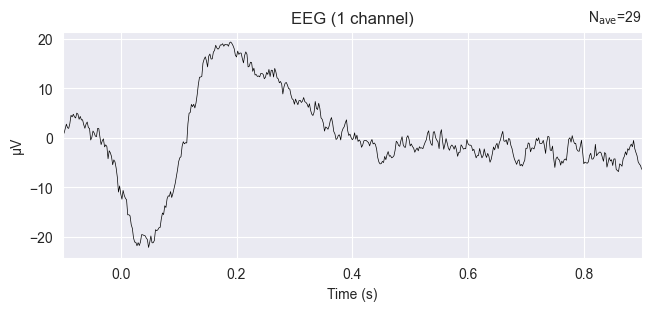

In [21]:
# fig = epochs_preprocessed.copy()['error_response'].pick(['FCz']).average().plot()

Flow TODO:
- read all files from preprocesses dir
- perform wavelet transform on all participants' error trials
- save the results (list of wavelets per participant with beh data) // dir wavelets
- create grand average
- create wavelet filter based on the grand average
- save the filter // dir utils
- read participants' tfrs
- apply filters and inverse transform;
- save the results (list of filtered signals per participant with beh data) // dir w_filtered_signal
- read participants' filtered trials
- create grand average
- create variability matrix based on grand average
- save variability matrix // dir utils
- create PCA
- save PCA components // dir utils
- read participants' filtered trials 
- filter with PCA
- save the results (list of filtered with wvts and PCA signals per participant with beh data) // dir w_pca_filtered_signal

---
## Wavelets transform

In [26]:
def signal_cwt(signal, central_freq = 6, signal_freq=500):
    x = signal.flatten()

    # construct wavelet function
    wavelet = Wavelet(('morlet', {'mu': central_freq}))
    Wx, scales = cwt(x, wavelet, fs=signal_freq)

    return Wx

def epochs_to_tfr(epochs, picks=['FCz', 'Cz'], events=['error_response']):
    '''
    
    :param epochs: 
    :param picks: 
    :param events: 
    :return: ndarray of shape (n_events, n_channels, n_freqs, n_timepoints)
    '''
    epochs_picked = epochs.copy()[events].pick(picks)
    tfr_epochs = []
    for idx, _ in enumerate(epochs_picked):
        epoch = epochs_picked[idx]
        epoch_data = epoch.get_data(copy=True)

        tfr_channel_data = []
        for ch_name, ch_idx in zip(epochs_picked.info['ch_names'],
                                   np.arange(0, len(epochs_picked.info['ch_names']))):
            channel_data = epoch_data[0,ch_idx,:]
    
            channel_wavelet_data = signal_cwt(channel_data)
            tfr_channel_data.append(channel_wavelet_data)
        tfr_epochs.append(tfr_channel_data)
    
    tfr_epochs = np.array(tfr_epochs)
    return tfr_epochs

def filter_signal(Wx, mask, wavelet, scales):
    time_domain_signal = icwt(mask * Wx, wavelet, scales)

    return time_domain_signal

def tfr_filter_epochs(tfr, mask, wavelet, scales):
    filtered_epochs = []
    for epochs in tfr:
        filtered_channel_data = []
        for channel_data in epochs:
            signal = channel_data
            reconstructed_signal = filter_signal(signal, mask, wavelet, scales)
            filtered_channel_data.append(reconstructed_signal)
        filtered_epochs.append(filtered_channel_data)

    filtered_epochs = np.array(filtered_epochs)    
    return filtered_epochs

In [27]:
def calculate_wavelet_filter(grand_average, central_freq = 6, signal_freq=500, threshold_point=0.85):
    x = grand_average.flatten()
    t = np.linspace(-0.1, 0.9, len(x))
    # construct wavelet function
    wavelet = Wavelet(('morlet', {'mu': central_freq}))
    Wx, scales = cwt(x, wavelet, fs=signal_freq)

    freq = scale_to_freq(scales, wavelet, N=len(x), fs=signal_freq)
    # Compute and normalize the power spectrum from the CWT coefficients
    power_spectrum = np.abs(Wx)**2
    normalized_power_spectrum = power_spectrum / np.sum(power_spectrum)

    # Flatten the normalized power spectrum for CDF calculation
    flattened_spectrum = normalized_power_spectrum.flatten()

    # Use the Kaplan–Meier estimator
    kmf = KaplanMeierFitter()
    kmf.fit(durations=flattened_spectrum, event_observed=np.ones_like(flattened_spectrum))

    # Get the CDF values from the Kaplan–Meier estimator
    cdf_values = 1 - kmf.survival_function_.KM_estimate

    # Calculate the threshold
    threshold = threshold_point * (np.max(cdf_values) - np.min(cdf_values)) + np.min(cdf_values)

    # Plot the empirical CDF and the filtering model
    plt.step(kmf.survival_function_.index, cdf_values, where='post', label='Empirical CDF')
    plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
    plt.title('Empirical CDF and Filtering Model')
    plt.xlabel('Wavelet Coefficient')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.show()

    # Find the value of wavelets coefficient that are above threshold
    cutoff_wavelet_index = np.where(cdf_values > threshold)[0][0]
    cutoff_wavelet_coef = kmf.survival_function_.index[cutoff_wavelet_index]
    print(f'Estimated threshold value for wavelet coefficients: {cutoff_wavelet_coef}')

    cwt_result_threshold_mask = np.where(normalized_power_spectrum >= cutoff_wavelet_coef, 1, 0)

    # Plot the CWT result
    plt.figure(figsize=(12, 16))

    plt.subplot(4, 1, 1)
    plt.imshow(np.abs(Wx), extent=[t[0], t[-1], freq[-1], freq[0]], aspect='auto', cmap='jet')
    plt.colorbar(label='Magnitude')
    plt.title('CWT Magnitude')

    # 
    plt.subplot(4, 1, 2)
    plt.imshow(normalized_power_spectrum, extent=[t[0], t[-1], freq[-1], freq[0]], aspect='auto', cmap='jet')
    plt.colorbar(label='Magnitude')
    plt.title('Normalized Power Spectrum')

    plt.subplot(4, 1, 3)
    plt.imshow(cwt_result_threshold_mask, extent=[t[0], t[-1], freq[-1], freq[0]], aspect='auto', cmap='jet')
    plt.colorbar(label='Magnitude')
    plt.title('Threshold Mask')

    plt.subplot(4, 1, 4)
    plt.imshow(cwt_result_threshold_mask*np.abs(Wx), extent=[t[0], t[-1], freq[-1], freq[0]], aspect='auto', cmap='jet')
    plt.colorbar(label='Magnitude')
    plt.title('Thresholded Grand Average - Examle')
    plt.show()

    return cwt_result_threshold_mask, wavelet, scales

In [106]:
picks=['FCz', 'Cz']
tfr_epochs = epochs_to_tfr(epochs_preprocessed)
tfr_epochs.shape

(29, 2, 266, 501)

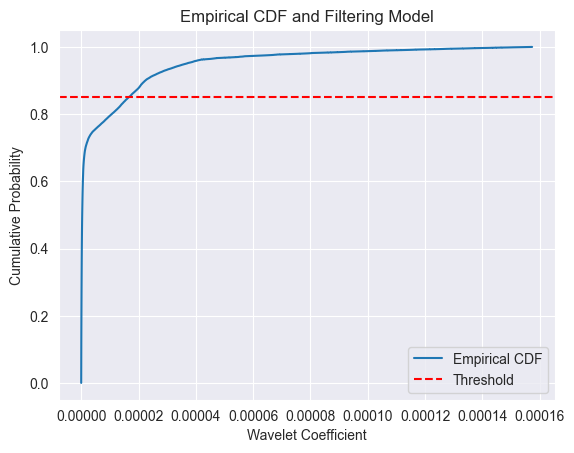

Estimated threshold value for wavelet coefficients: 1.6557929484406486e-05


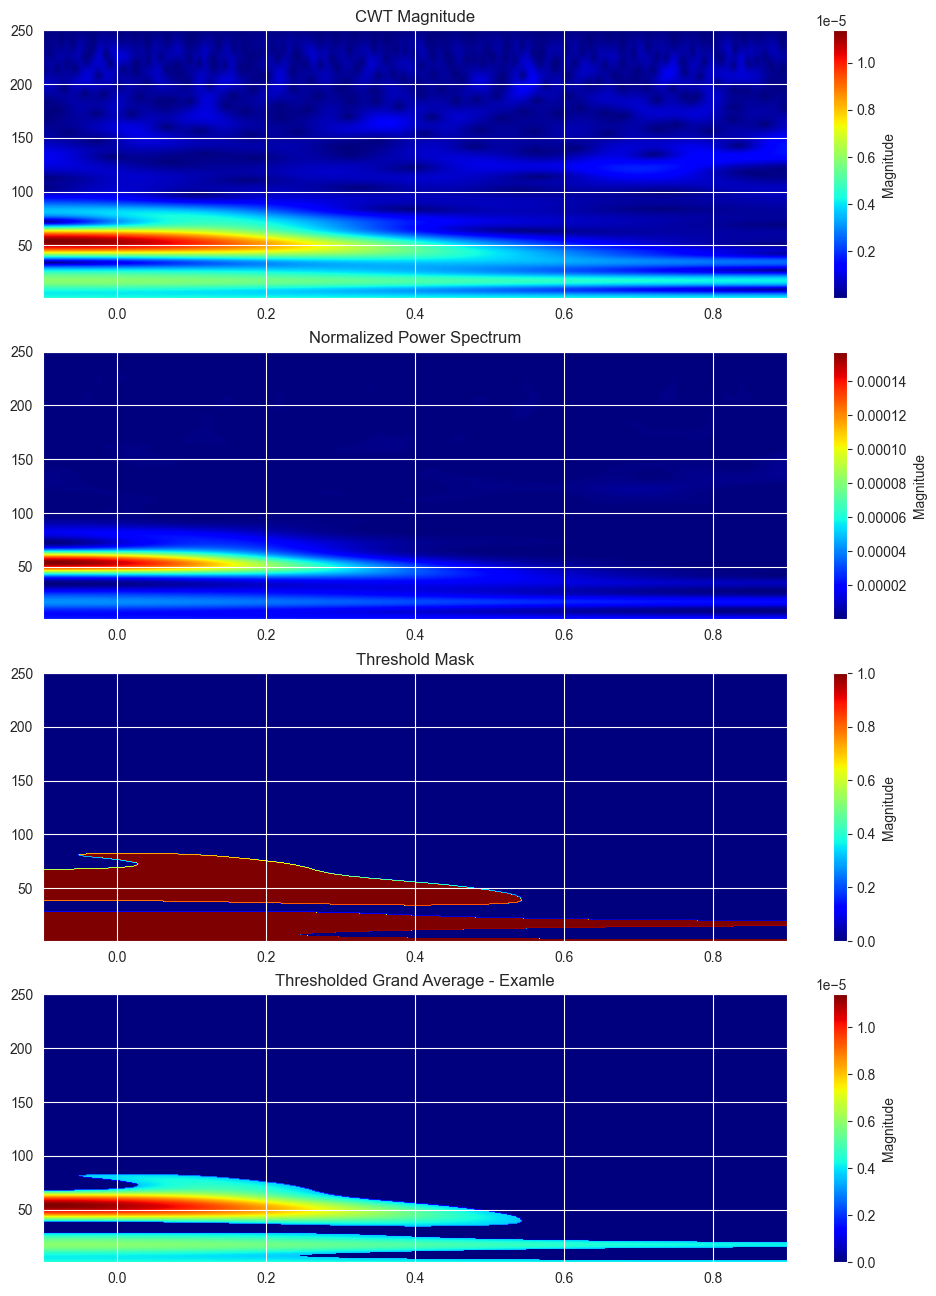

In [110]:
pick = ['FCz']
grand_average = epochs_preprocessed['error_response'].average().get_data(picks=pick)
cwt_result_threshold_mask, wavelet, scales = calculate_wavelet_filter(grand_average, central_freq=6, threshold_point=0.85)

In [111]:
reconstructed_epochs = tfr_filter_epochs(
    tfr_epochs, 
    cwt_result_threshold_mask, 
    wavelet=wavelet, 
    scales=scales
)
reconstructed_epochs.shape

(29, 2, 501)

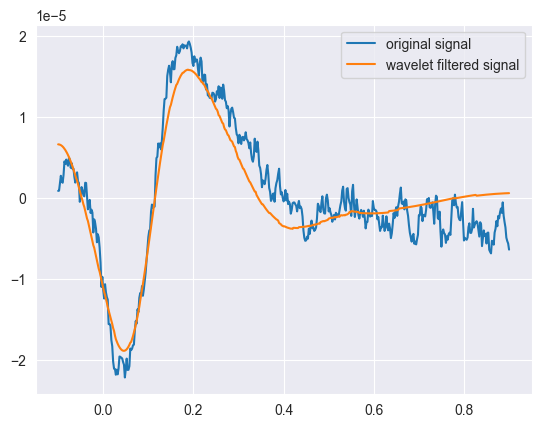

In [206]:
x = np.linspace(-0.1, 0.9, reconstructed_epochs.shape[-1])
plt.plot(x, epochs_preprocessed['error_response'].average().get_data(picks=['FCz']).flatten(), label='original signal')
plt.plot(x, np.mean(reconstructed_epochs, axis=0)[0], label='wavelet filtered signal')
plt.legend()

## Generate PCA components:

1. Average filtered with wavelets single trials into grand average.
2. Create variability matrix base on the grand average: variability in peak latency and variability in waveform compression.
3. Perform PCA decomposition on set of modified ERPs. 

In [241]:
def ms_to_tp(value_in_ms, freq=500):
    """
    Only for relative conversion of the lengths
    :param value_in_ms: 
    :param freq: 
    :return: 
    """
    ms_unit = freq/1000
    value_in_tp = int(value_in_ms*ms_unit)
    return value_in_tp

def stretch(xs, coef, centre):
    """Scale a list by a coefficient around a point in the list.

    Parameters
    ----------
    xs : list
        Input values.
    coef : float
        Coefficient to scale by.
    centre : int
        Position in the list to use as a centre point.

    Returns
    -------
    list

    """
    grain = 100

    stretched_array = np.repeat(xs, grain * coef)
    stretched_array = np.array(stretched_array)
    result = [chunk.mean() for chunk in chunks(stretched_array, grain)]

    pivot_point = int(centre * coef)
    first = pivot_point - centre
    last = pivot_point + len(xs) - centre
    result = result[first:last]

    assert len(result) == len(xs), "Length should be preserved"
    return result


def chunks(iterable, n):
    """
    Yield successive n-sized chunks from iterable.
    Source: http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks-in-python#answer-312464

    """
    for i in range(0, len(iterable), n):
        yield iterable[i:i + n]


def generate_variability_matrix(X):
    '''
    
    :param X: ndarray of shape (n_timepoints,)
        Grand Average on given channel 
    :return: 
    '''
    # Find the peak latency in the grand average signal /in tp
    peak_latency_tp = np.argmin(X)
    print(f'Peak latency in tp: {peak_latency_tp}')

    # Parameters
    latency_shifts = np.arange(-ms_to_tp(50), ms_to_tp(60), ms_to_tp(5))  # From -50 to 50 ms in steps of 5 ms
    width_changes = np.arange(1, 1.5, 0.02)  # From 1 to 2 in steps of 0.05

    # Initialize a list to store modified ERP responses
    modified_responses = []

    # Enumerate through latency shifts and width changes
    for width_change in width_changes:
        for latency_shift in latency_shifts:
        # Apply latency shift
            evoked_shifted = np.roll(X.flatten(), int(latency_shift))

            # Calculate the stretched array
            evoked_stretched = np.array(stretch(evoked_shifted, coef=width_change, centre=peak_latency_tp))
            modified_responses.append(evoked_stretched)

    # Convert the list of modified responses to a numpy array
    modified_responses = np.array(modified_responses)

    return modified_responses

def create_variability_PCA_components(variability_matrix, n_components=3):
    pca = PCA(n_components=n_components)
    X = variability_matrix.T
    X_transformed = pca.fit_transform(X)
    
    return X_transformed

In [242]:
# 1. Create grand average todo
grand_average = np.mean(reconstructed_epochs, axis=0)[0]

Peak latency in tp: 73


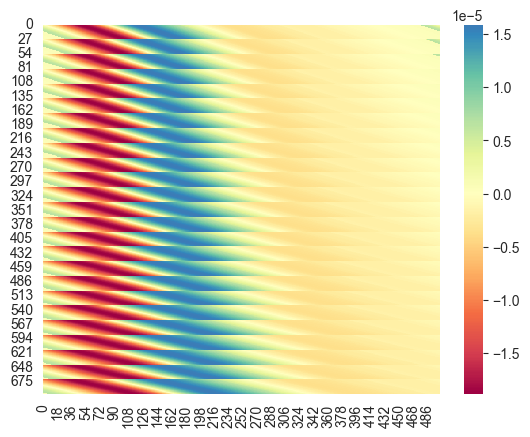

In [243]:
# 2. Generate variability matrix
variability_matrix = generate_variability_matrix(grand_average)

sns.heatmap(
    variability_matrix,
    center=0,
    cmap='Spectral'  
)

plt.show()

In [244]:
# 3. get PCA components
pca = create_variability_PCA_components(variability_matrix)
pca.shape

(501, 3)

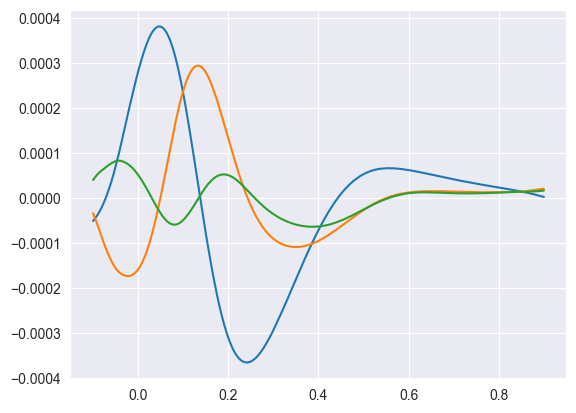

In [245]:
PCA_comp = pca.T
x = np.linspace(-0.1, 0.9, reconstructed_epochs.shape[-1])
plt.plot(x, PCA_comp[0])
plt.plot(x, PCA_comp[1])
plt.plot(x, PCA_comp[2])

plt.show()

### Regress signal on PCA components

In [246]:
def regress_signal_on_PCA(epochs, PCA_components):
    filtered_epochs = []
    
    for epoch in epochs:
        filtered_channel_data = []
        for channel_data in epoch:
            lm = LinearRegression()
            lm.fit(X=PCA_components, y=channel_data.flatten())
            epoch_pred = lm.predict(PCA_components)
            filtered_channel_data.append(epoch_pred)
        filtered_epochs.append(filtered_channel_data)
    filtered_epochs = np.array(filtered_epochs)
    return filtered_epochs

In [253]:
filtered_pca_epochs = regress_signal_on_PCA(reconstructed_epochs, pca)

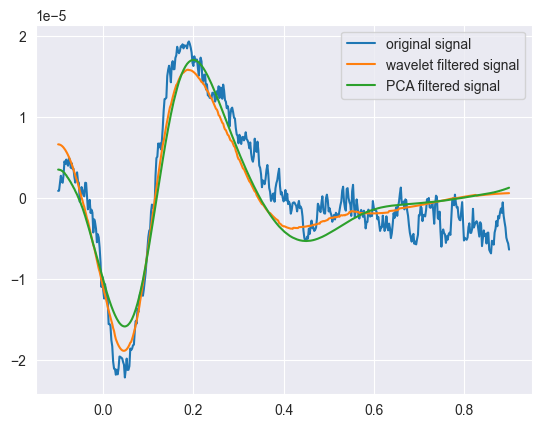

In [255]:
x = np.linspace(-0.1, 0.9, reconstructed_epochs.shape[-1])

plt.plot(x, epochs_preprocessed['error_response'].average().get_data(picks=['FCz']).flatten(), label='original signal')
plt.plot(x, np.mean(reconstructed_epochs, axis=0)[0], label='wavelet filtered signal')
plt.plot(x, np.mean(filtered_pca_epochs, axis=0)[0], label='PCA filtered signal')

plt.legend()

---
## For testing

In [5]:
input_fname = 'data/raw/A-GNG-000.bdf'
raw = mne.io.read_raw_bdf(
    input_fname,
    eog=['EXG1', 'EXG2', 'EXG3', 'EXG4'],
    exclude=['EXG5', 'EXG6'],
    preload=True
)

try:
    raw = raw.set_montage('biosemi64')
except ValueError as e:
    if '[\'EXG7\', \'EXG8\']' in e.args[0]:
        raw = raw.set_montage('biosemi64', on_missing='ignore')
        print('On missing')
    else:
        print('Lacks important channels!')


file_path = 'data/raw/triggerMap_A-GNG-000.txt'
trigger_map = read_trigger_map(file_path)
raw_new_triggers = replace_trigger_names(raw, trigger_map)

Extracting EDF parameters from /Users/anuszka/Projects/ERPinability/data/raw/A-GNG-000.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1782783  =      0.000 ...  1740.999 secs...
On missing
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
1391 events found on stim channel Status
Event IDs: [65281 65282 65283 65284 65285 65286 65287 65288]


In [6]:
# 1. re-reference: to mastoids
raw_ref = raw_new_triggers.copy().set_eeg_reference(ref_channels=['EXG7', 'EXG8'])

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


In [7]:
# 2. Resampling
raw_resampled = raw_ref.copy().resample(sfreq=500)

Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
1391 events found on stim channel Status
Event IDs: [65281 65282 65283 65284 65285 65286 65287 65288]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
1391 events found on stim channel Status
Event IDs: [65281 65282 65283 65284 65285 65286 65287 65288]


In [8]:
# # (Filter)
# # 2. 4-th order Butterworth filters
# raw_filtered = raw_resampled.copy().filter(
#     l_freq=.1,
#     h_freq=30.0,
#     n_jobs=10,
#     method='iir',
#     iir_params=None,
#     picks=['eeg', 'eog']
# )

In [9]:
# 3. Detrending, Segmentation, and first baseline correction

epochs = create_epochs(
    # raw_resampled,
    raw_resampled,
    tmin = -.1,
    tmax = .9,
    baseline = (-0.1, 0),
    detrend = 1,
    events_to_select = response_event_dict,  # response_event_dict
    new_events_dict = new_response_event_dict,  # new_response_event_dict
    events_mapping = events_mapping,  # events_mapping
    reject = None,
    reject_by_annotation = False,
)

Used Annotations descriptions: ['RE*ex*1_n*1_c_1*num_separator', 'RE*ex*1_n*1_c_2*num_separator', 'RE*ex*1_n*2_c_1*num_separator', 'RE*ex*2_n*1_c_1*num_separator', 'RE*ex*2_n*2_c_1*num_separator', 'RE*ex*2_n*2_c_2*num_separator']
Not setting metadata
253 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 253 events and 501 original time points ...
0 bad epochs dropped


In [11]:
# 4. ocular artifact correction with Gratton
epochs_eog_corrected = ocular_correction_gratton(epochs)

No projector specified for this dataset. Please consider the method self.add_proj.
No projector specified for this dataset. Please consider the method self.add_proj.


In [12]:
# 5. Second re-baseline
epochs_eog_corrected.apply_baseline()

Applying baseline correction (mode: mean)


Number of events,253
Events,correct_response: 224error_response: 29
Time range,-0.100 – 0.900 s
Baseline,-0.100 – 0.000 s


In [13]:
# 6. Mark bad trials
drop_log = find_bad_trials(epochs_eog_corrected, picks=['FCz','Cz'])
drop_log

((),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),


In [15]:
# 7. Reject bad trials
clean_epochs, drop_log = reject_bad_trials(epochs_eog_corrected, drop_log)
print(clean_epochs)

Dropped 0 epochs: 
<Epochs |  253 events (all good), -0.1 – 0.9 s, baseline -0.1 – 0 s, ~67.8 MB, data loaded,
 'correct_response': 224
 'error_response': 29>


Need more than one channel to make topography for eeg. Disabling interactivity.


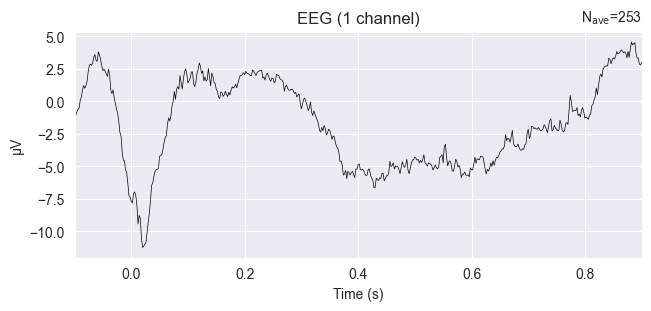

In [17]:
fig = clean_epochs.copy().pick(['FCz']).average().plot()

## Wavelets transform

In [202]:
pick = ['FCz']
grand_average = clean_epochs['error_response'].average().get_data(picks=pick)

In [589]:
def calculate_wavelet_filter(grand_average, central_freq = 6, signal_freq=500):
    x = grand_average.flatten()
    
    # construct wavelet function
    wavelet = Wavelet(('morlet', {'mu': central_freq}))
    Wx, scales = cwt(x, wavelet, fs=500)
    
    freq = scale_to_freq(scales, wavelet, N=len(x), fs=signal_freq)
    print(freq)
    # Compute and normalize the power spectrum from the CWT coefficients
    power_spectrum = np.abs(Wx)**2
    normalized_power_spectrum = power_spectrum / np.sum(power_spectrum)
    
    # Flatten the normalized power spectrum for CDF calculation
    flattened_spectrum = normalized_power_spectrum.flatten()
    
    # Use the Kaplan–Meier estimator from the lifelines library
    kmf = KaplanMeierFitter()
    kmf.fit(durations=flattened_spectrum, event_observed=np.ones_like(flattened_spectrum))
    
    # Get the CDF values from the Kaplan–Meier estimator
    cdf_values = 1 - kmf.survival_function_.KM_estimate
    
    # Calculate the threshold
    threshold = 0.85 * (np.max(cdf_values) - np.min(cdf_values)) + np.min(cdf_values)
    
    # Plot the empirical CDF and the filtering model
    plt.step(kmf.survival_function_.index, cdf_values, where='post', label='Empirical CDF')
    plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
    plt.title('Empirical CDF and Filtering Model')
    plt.xlabel('Wavelet Coefficient')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.show()
    
    # find the value of wavelets coefficient that are above threshold
    cutoff_wavelet_index = np.where(cdf_values > threshold)[0][0]
    cutoff_wavelet_coef = kmf.survival_function_.index[cutoff_wavelet_index]
    print(f'Estimated threshold value for wavelet coefficients: {cutoff_wavelet_coef}')
    
    cwt_result_threshold_mask = np.where(normalized_power_spectrum >= cutoff_wavelet_coef, 1, 0)
    
    # Plot the CWT result
    plt.figure(figsize=(12, 16))  
    
    plt.subplot(4, 1, 1)
    plt.imshow(abs_cwt, extent=[t[0], t[-1], freq[-1], freq[0]], aspect='auto', cmap='jet')
    plt.colorbar(label='Magnitude')
    plt.title('CWT Magnitude')
    
    # 
    plt.subplot(4, 1, 2)
    plt.imshow(normalized_power_spectrum, extent=[t[0], t[-1], freq[-1], freq[0]], aspect='auto', cmap='jet')
    plt.colorbar(label='Magnitude')
    plt.title('Normalized Power Spectrum')
    
    plt.subplot(4, 1, 3)
    plt.imshow(cwt_result_threshold_mask, extent=[t[0], t[-1], freq[-1], freq[0]], aspect='auto', cmap='jet')
    plt.colorbar(label='Magnitude')
    plt.title('Threshold Mask')
    
    plt.subplot(4, 1, 4)
    plt.imshow(cwt_result_threshold_mask*np.abs(Wx), extent=[t[0], t[-1], freq[-1], freq[0]], aspect='auto', cmap='jet')
    plt.colorbar(label='Magnitude')
    plt.title('Thresholded Grand Average - Examle')
    plt.show()
    
    return cwt_result_threshold_mask, wavelet, scales

def filter_signal(Wx, mask, wavelet, scales):
    time_domain_signal = icwt(mask * Wx, wavelet, scales)
    
    return time_domain_signal

[250.        250.        250.        250.        250.        250.
 250.        250.        250.        250.        250.        249.0234375
 244.140625  238.28125   233.3984375 228.515625  223.6328125 218.75
 213.8671875 209.9609375 205.078125  201.171875  196.2890625 192.3828125
 188.4765625 184.5703125 179.6875    176.7578125 172.8515625 168.9453125
 165.0390625 162.109375  158.203125  155.2734375 151.3671875 148.4375
 145.5078125 141.6015625 138.671875  135.7421875 132.8125    129.8828125
 126.953125  125.        122.0703125 119.140625  117.1875    114.2578125
 112.3046875 109.375     107.421875  104.4921875 102.5390625 100.5859375
  98.6328125  95.703125   93.75       91.796875   89.84375    87.890625
  85.9375     83.984375   83.0078125  81.0546875  79.1015625  77.1484375
  76.171875   74.21875    72.265625   71.2890625  69.3359375  68.359375
  66.40625    65.4296875  63.4765625  62.5        60.546875   59.5703125
  58.59375    57.6171875  55.6640625  54.6875     53.7109375  52.734

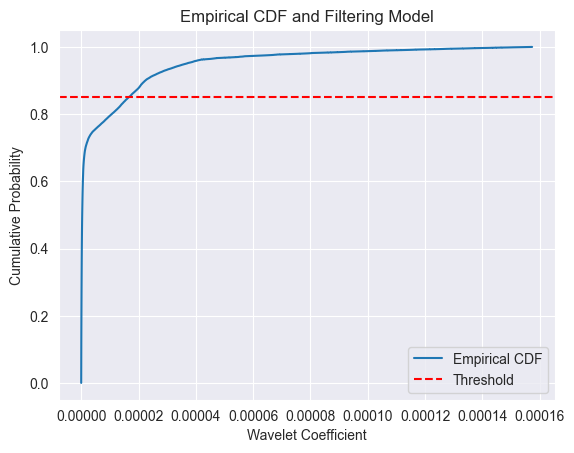

Estimated threshold value for wavelet coefficients: 1.6557929484406486e-05


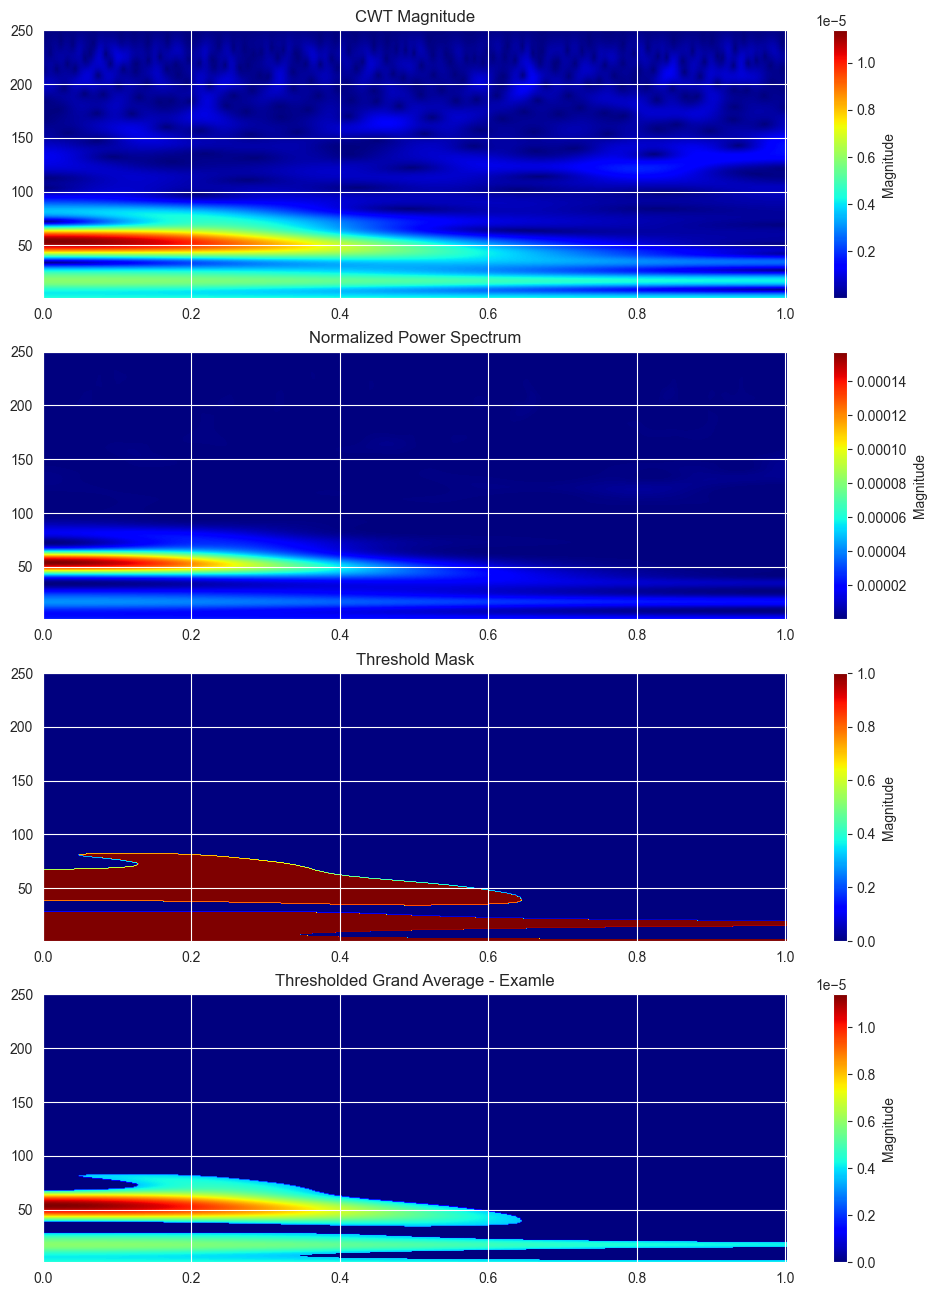

In [590]:
cwt_result_threshold_mask, wavelet, scales = calculate_wavelet_filter(grand_average, central_freq=6)

In [580]:
x = grand_average.flatten()

# construct wavelet function
wavelet_this = Wavelet(('morlet', {'mu': 6}))
Wx, scales_this = cwt(x, wavelet, fs=500)

In [581]:
filtered_signal = filter_signal(Wx, cwt_result_threshold_mask, wavelet, scales)

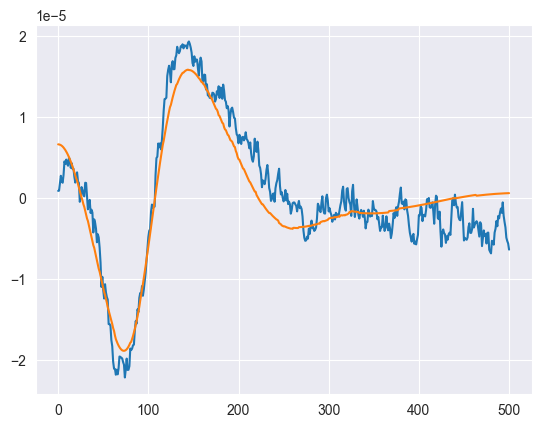

In [582]:
plt.plot(x)
plt.plot(filtered_signal)

In [ ]:
freq = scale_to_freq(scales, wavelet, N=len(x), fs=500)

In [600]:
import pandas as pd
data = pd.DataFrame(abs(Wx), index=freq, columns=np.linspace(-0.1, 0.9, len(x)))

In [601]:
data

,-0.100,-0.098,-0.096,-0.094,-0.092,-0.090,-0.088,-0.086,-0.084,-0.082,...,0.882,0.884,0.886,0.888,0.890,0.892,0.894,0.896,0.898,0.900
250.000000,8.870551e-09,1.621957e-08,2.682803e-08,3.470964e-08,4.001685e-08,4.524895e-08,5.138408e-08,5.601562e-08,5.616278e-08,5.052322e-08,...,9.096043e-08,8.138776e-08,6.765738e-08,5.118092e-08,3.426373e-08,2.025055e-08,1.532602e-08,2.017306e-08,2.557748e-08,2.767609e-08
250.000000,8.869363e-09,1.809542e-08,3.066927e-08,3.981691e-08,4.591162e-08,5.199490e-08,5.922971e-08,6.472177e-08,6.490357e-08,5.818755e-08,...,1.067175e-07,9.553285e-08,7.939941e-08,5.994771e-08,3.984302e-08,2.293945e-08,1.687665e-08,2.297852e-08,2.959152e-08,3.213345e-08
250.000000,8.432961e-09,2.006784e-08,3.486422e-08,4.538855e-08,5.231412e-08,5.933745e-08,6.783843e-08,7.433668e-08,7.457187e-08,6.661617e-08,...,1.245999e-07,1.116075e-07,9.274631e-08,6.988781e-08,4.609455e-08,2.575637e-08,1.826625e-08,2.596636e-08,3.404045e-08,3.710950e-08
250.000000,7.416408e-09,2.216190e-08,3.941404e-08,5.139832e-08,5.917206e-08,6.721829e-08,7.716931e-08,8.484072e-08,8.515845e-08,7.579273e-08,...,1.447208e-07,1.297253e-07,1.077989e-07,8.107529e-08,5.305100e-08,2.865810e-08,1.935953e-08,2.909891e-08,3.892616e-08,4.261650e-08
250.000000,5.656900e-09,2.444008e-08,4.432067e-08,5.780284e-08,6.640393e-08,7.554435e-08,8.714708e-08,9.618250e-08,9.662688e-08,8.568144e-08,...,1.671498e-07,1.499655e-07,1.246338e-07,9.357127e-08,6.074366e-08,3.160571e-08,1.998657e-08,3.233265e-08,4.424231e-08,4.865698e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.976562,4.116553e-06,4.116595e-06,4.116615e-06,4.116611e-06,4.116584e-06,4.116533e-06,4.116457e-06,4.116359e-06,4.116237e-06,4.116092e-06,...,2.567642e-06,2.566765e-06,2.565926e-06,2.565124e-06,2.564361e-06,2.563636e-06,2.562948e-06,2.562300e-06,2.561688e-06,2.561116e-06
0.976562,4.147614e-06,4.147646e-06,4.147660e-06,4.147656e-06,4.147634e-06,4.147596e-06,4.147538e-06,4.147464e-06,4.147372e-06,4.147262e-06,...,3.061067e-06,3.060510e-06,3.059979e-06,3.059471e-06,3.058987e-06,3.058527e-06,3.058092e-06,3.057680e-06,3.057294e-06,3.056931e-06
0.976562,4.205783e-06,4.205804e-06,4.205813e-06,4.205810e-06,4.205793e-06,4.205765e-06,4.205723e-06,4.205669e-06,4.205604e-06,4.205525e-06,...,3.476719e-06,3.476370e-06,3.476036e-06,3.475717e-06,3.475413e-06,3.475124e-06,3.474851e-06,3.474592e-06,3.474350e-06,3.474123e-06
0.976562,4.273406e-06,4.273419e-06,4.273424e-06,4.273420e-06,4.273408e-06,4.273387e-06,4.273359e-06,4.273322e-06,4.273277e-06,4.273224e-06,...,3.809239e-06,3.809026e-06,3.808824e-06,3.808629e-06,3.808444e-06,3.808269e-06,3.808103e-06,3.807947e-06,3.807799e-06,3.807662e-06


<Axes: >

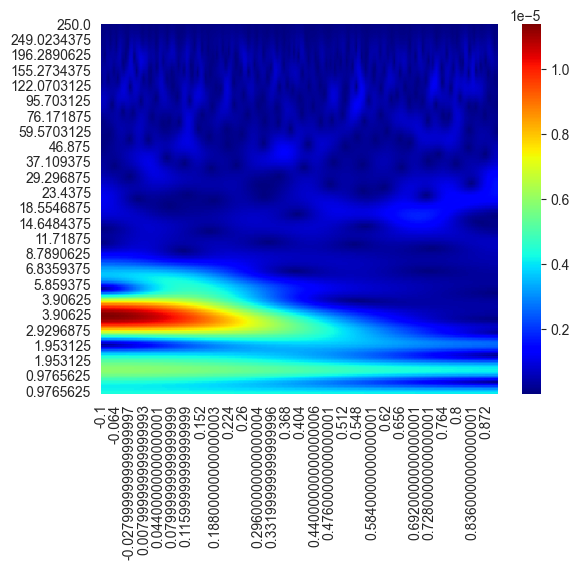

In [602]:
sns.heatmap(data, cmap='jet', )

## Regress single trial ERP on PCA components

In [59]:
lm = LinearRegression()
epochs_regressed=[]

for idx, _ in enumerate(clean_epochs['error_response']):
    epoch_data = clean_epochs['error_response'][idx].get_data(picks='FCz', tmin=-0.1, tmax=0.5).flatten()
    lm.fit(X=X_transformed, y=epoch_data)
    epoch_pred = lm.predict(X_transformed)
    epochs_regressed.append(epoch_pred)
    
epochs_regressed = np.array(epochs_regressed)
print(epochs_regressed.shape)

(29, 300)


## Generate PCA components:

1. Average filtered with wavelets single trials into grand average.
2. Create variability matrix base on the grand average: variability in peak latency and variability in waveform compression.
3. Perform PCA decomposition on set of modified ERPs. 

In [23]:
# 1. Create grand average

In [24]:
pick = ['FCz']
grand_average = clean_epochs['error_response'].average().get_data(picks=pick, tmin=-0.1, tmax=0.5)

In [37]:
def ms_to_tp(value_in_ms, freq=500):
    """
    Only for relative conversion of the lengths
    :param value_in_ms: 
    :param freq: 
    :return: 
    """
    ms_unit = freq/1000
    value_in_tp = int(value_in_ms*ms_unit)
    return value_in_tp

def stretch(xs, coef, centre):
    """Scale a list by a coefficient around a point in the list.

    Parameters
    ----------
    xs : list
        Input values.
    coef : float
        Coefficient to scale by.
    centre : int
        Position in the list to use as a centre point.

    Returns
    -------
    list

    """
    grain = 100

    stretched_array = np.repeat(xs, grain * coef)
    stretched_array = np.array(stretched_array)
    result = [chunk.mean() for chunk in chunks(stretched_array, grain)]

    pivot_point = int(centre * coef)
    first = pivot_point - centre
    last = pivot_point + len(xs) - centre
    result = result[first:last]

    assert len(result) == len(xs), "Length should be preserved"
    return result


def chunks(iterable, n):
    """
    Yield successive n-sized chunks from iterable.
    Source: http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks-in-python#answer-312464

    """
    for i in range(0, len(iterable), n):
        yield iterable[i:i + n]


def generate_variability_matrix(X):
    '''
    
    :param X: ndarray of shape (n_timepoints,)
        Grand Average on given channel 
    :return: 
    '''
    # Find the peak latency in the grand average signal /in tp
    peak_latency_tp = np.argmin(X)
    print(f'Peak latency in tp: {peak_latency_tp}')

    # Parameters
    latency_shifts = np.arange(-ms_to_tp(50), ms_to_tp(50), ms_to_tp(2))  # From -50 to 50 ms in steps of 5 ms
    width_changes = np.arange(1, 1.5, 0.02)  # From 1 to 2 in steps of 0.05

    # Initialize a list to store modified ERP responses
    modified_responses = []

    # Enumerate through latency shifts and width changes
    for width_change in width_changes:
        for latency_shift in latency_shifts:
        # Apply latency shift
            evoked_shifted = np.roll(X.flatten(), int(latency_shift))

            # Calculate the stretched array
            evoked_stretched = np.array(stretch(evoked_shifted, coef=width_change, centre=peak_latency_tp))
            modified_responses.append(evoked_stretched)

    # Convert the list of modified responses to a numpy array
    modified_responses = np.array(modified_responses)

    return modified_responses

In [40]:
# 2. Generate variability matrix
variability_matrix = generate_variability_matrix(grand_average)

sns.heatmap(
    variability_matrix,
    center=0,
    cmap='Spectral'  
)

plt.show()

Peak latency in tp: 66


In [41]:
# 3. fit PCA
pca = PCA(n_components=3)
X = variability_matrix.T
X_transformed = pca.fit_transform(X)

In [43]:
PCA_comp = X_transformed.T
x = np.linspace(0, 0.5, len(variability_matrix[0]))
plt.plot(x, PCA_comp[0])
plt.plot(x, PCA_comp[1])
plt.plot(x, PCA_comp[2])

plt.show()

In [44]:
# def pre_process_eeg(input_fname, trigger_map=None, parameters=None):
#     raw = mne.io.read_raw_bdf(input_fname, eog=['EX7', 'EX8'])
# 
#     # 1. re-reference: to mastoids
#     raw.set_eeg_reference(ref_channels=['M1', 'M2'])
# 
#     # 2. segmentation -100 to 900 ms around the response
#     epochs = create_epochs(raw_filtered, tmin=-.1, tmax=.9)
# 
#     # 3. ocular artifact correction with ICA
#     refined_epochs = ocular_correction_gratton(epochs)
# 
#     # 6. Second re-baseline
#     refined_epochs.apply_baseline()
#
#     # 7. Find bad trials: trials in which the EEG signal at the FCz or Cz site was greater than ± 150 μV are marked
#     drop_log = find_bad_trials(refined_epochs, picks=['FCz','Cz'])
# 
#     # 9. Wavelet filter (1 to 30 Hz in steps of 0.3 Hz)
#     # todo

#     # 10. Slicing wavelets: -100 - 500 around response
#     # todo
#
#     # 11. PCA on grand average of inverted wavelets (after wavelets -> invert to get signal, average, do PCA)
#     # todo -> this on cleaned_epochs = reject_bad_trials(refined_epochs, drop_log))
#
#     # 12. Regression: Y (invert single-trial wavelets) = PCA_3 .fit(); y_hat = .predict()
#     # todo
#
#     # 13. peak amplitude of y_hat (single trail denoised signal)
#     # todo
#


In [201]:
response_event_dict = {
    'Stimulus/RE*ex*1_n*1_c_1*R*FB': 10003,
    'Stimulus/RE*ex*1_n*1_c_1*R*FG': 10004,
    'Stimulus/RE*ex*1_n*1_c_2*R': 10005,
    'Stimulus/RE*ex*1_n*2_c_1*R': 10006,
    'Stimulus/RE*ex*2_n*1_c_1*R': 10007,
    'Stimulus/RE*ex*2_n*2_c_1*R*FB': 10008,
    'Stimulus/RE*ex*2_n*2_c_1*R*FG': 10009,
    'Stimulus/RE*ex*2_n*2_c_2*R': 10010,
}

new_response_event_dict = {"correct_response": 0, "error_response": 1}

events_mapping = {
    'correct_response': [10003, 10004, 10008, 10009],
    'error_response': [10005, 10006, 10007, 10010],
}

In [202]:
raw = mne.io.read_raw_brainvision(
    vhdr_fname = 'data/GNG_AA0303-64 el.vhdr', preload=True
)

Extracting parameters from data/GNG_AA0303-64 el.vhdr...
Setting channel info structure...
Reading 0 ... 55668  =      0.000 ...   217.453 secs...


In [203]:
raw_resampled = raw.copy().resample(sfreq=500)

In [204]:
# 2. 4-th order Butterworth filters
raw_filtered = raw_resampled.copy().filter(
        l_freq=.1,
        h_freq=30.0,
        n_jobs=10,
        method='iir',
        iir_params=None,
)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 30.00 Hz: -6.02, -6.02 dB


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.8s finished


In [243]:
epochs = create_epochs(
    raw_filtered,
    tmin=-.1,
    tmax=.5,
    baseline=(-0.1, 0),
    detrend=1,
    events_to_select=response_event_dict,  # response_event_dict
    new_events_dict=new_response_event_dict,  # new_response_event_dict
    events_mapping=events_mapping,  # events_mapping
    reject=None,
    reject_by_annotation=False,
)

Used Annotations descriptions: ['Stimulus/RE*ex*1_n*1_c_1*R*FB', 'Stimulus/RE*ex*1_n*1_c_1*R*FG', 'Stimulus/RE*ex*1_n*1_c_2*R', 'Stimulus/RE*ex*1_n*2_c_1*R', 'Stimulus/RE*ex*2_n*1_c_1*R', 'Stimulus/RE*ex*2_n*2_c_1*R*FB', 'Stimulus/RE*ex*2_n*2_c_1*R*FG', 'Stimulus/RE*ex*2_n*2_c_2*R']
Not setting metadata
311 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 311 events and 346 original time points ...
0 bad epochs dropped


In [244]:
epochs_copy = epochs.copy()
epochs_picked_channels = epochs_copy.pick(picks=['FCz', 'Cz'])

epochs_picked_channels.drop_bad()
drop_log = epochs_picked_channels.drop_log
print(drop_log)

# channels with more than a 30 μV difference with the nearest six neighbors
for idx, _ in enumerate(epochs_picked_channels):
    epoch = epochs[idx]
    epoch_data = epoch.get_data(copy=True)
    # epoch_data[0] = np.random.normal(0,5,epoch_data[0].shape)
    for ch_name, ch_idx in zip(epochs_picked_channels.info['ch_names'], np.arange(0, len(epochs_picked_channels.info['ch_names']))):
        channel_data = epoch_data[0,ch_idx,:]

        # EEG signal at the FCz or Cz site was greater than ± 150 μV were removed
        if(abs(channel_data) > 150e-6).any():
            print(f'BAD------ trail index {idx}, channel: {ch_name}')
            new_drop_log_item = drop_log[idx] + (ch_name, ) if ch_name not in drop_log[idx] else drop_log[idx]
            drop_log = tuple(new_drop_log_item if i == idx else item for i, item in enumerate(drop_log))


((), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (),

In [245]:
drop_log

((),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),


In [246]:

epochs_copy = epochs.copy()
cleaned_epochs = reject_bad_trials(epochs_copy, drop_log)
evokes = []
picks=['FCz', 'Cz']

for ch_name in picks:
    evoked = cleaned_epochs.copy().pick(picks=ch_name)['error_response'].average()
    print(evoked)
    evokes.append(evoked)
    # print(X.shape)

#     pca = PCA(n_components=3)
#     X_transformed = pca.fit_transform(X)
#     transformed_evokes[ch_name] = X_transformed

Dropped 0 epochs: 
<Evoked | 'error_response' (average, N=87), -0.1 – 0.59 s, baseline -0.1 – 0 s, 1 ch, ~37 kB>
<Evoked | 'error_response' (average, N=87), -0.1 – 0.59 s, baseline -0.1 – 0 s, 1 ch, ~37 kB>


In [247]:
# if len(epochs) == len(drop_log):
#     epochs_to_drop_indices = []
#     for idx, item in enumerate(drop_log):
#         if ('FCz' in item) or ('Cz' in item):
#             print(f'In item: {idx}')
#             epochs_to_drop_indices.append(idx)
# 
#     clean_epochs = epochs.copy().drop(
#         indices = epochs_to_drop_indices,
#         reason = 'EXCEED 150uV', 
#     )
#     
# else:
#     print(f'Epochs length is not equal drop_log length:\nepochs: {len(epochs)}\ndrop_log{len(drop_log)}')
#     

In [209]:
# _, value = mne.preprocessing.peak_finder(evokes[0].copy().crop(0.02, 0.1).get_data().flatten(), extrema=-1)
# idx, _ = np.where(evokes[0] == value)
_, lat, amp = evokes[1].get_peak(tmin=0.02, tmax=0.1, return_amplitude=True, mode='abs')
print(lat)

0.1


Need more than one channel to make topography for eeg. Disabling interactivity.


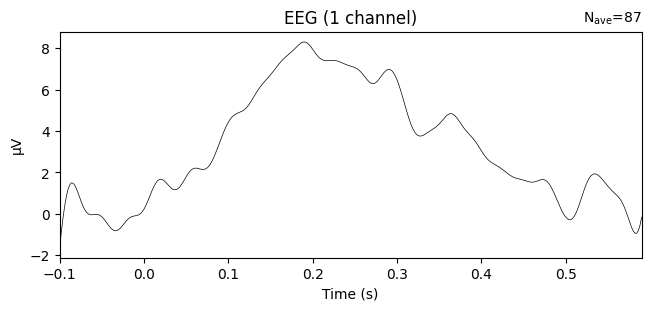

In [210]:
fig = evokes[0].plot()

In [211]:
evokes[0].get_data().shape

(1, 346)

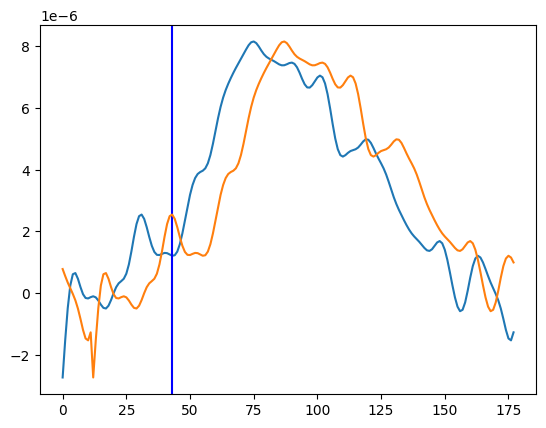

In [165]:
plt.plot(evokes[1])
plt.axvline(x = idx, color = 'b')
plt.plot(np.roll(evokes[1],12))

In [194]:
idx

array([43])

In [365]:
grand_average = clean_epochs['error_response'].average().get_data(picks='FCz', tmin=-0.1, tmax=0.5)
grand_average = grand_average.flatten()

In [366]:
# x = np.linspace(-0.1, 0.5, len(grand_average))
# plt.plot(x, grand_average)
# 
# plt.show()

In [367]:
vm = generate_variability_matrix(grand_average)

Peak latency in tp: 66
(300,)


AssertionError: Length should be preserved

In [ ]:
# sns.heatmap(
#     vm,
#     center=0,
#     cmap='Spectral',
#     # xticklabels=np.arange(0, len(grand_average))
# )
# plt.show()

In [368]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X = vm.T
X_transformed = pca.fit_transform(X)

In [369]:
print(X_transformed.shape)

PCA_comp = X_transformed.T

x = np.linspace(0, 0.5, len(vm[0]))
plt.plot(x, PCA_comp[0])
plt.plot(x, PCA_comp[1])
plt.plot(x, PCA_comp[2])

plt.show()

(300, 3)


In [370]:
from sklearn.linear_model import LinearRegression

results=[]

lm = LinearRegression()

for idx, _ in enumerate(clean_epochs['error_response']):
    epoch_data = clean_epochs['error_response'][idx].get_data(picks='FCz', tmin=-0.1, tmax=0.5).flatten()
    lm.fit(X=X_transformed, y=epoch_data)
    epoch_pred = lm.predict(X_transformed)
    results.append(epoch_pred)

In [371]:
len(results)

29

In [359]:
x = np.linspace(-0.1, 0.5, len(grand_average))

for i in range(0, len(results)):
    plt.figure()
    plt.plot(x, clean_epochs['error_response'][i].get_data(picks='FCz', tmin=-0.1, tmax=0.5).flatten())
    plt.plot(x, results[i].flatten())
    
plt.show()

/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_89302/1285389838.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


In [159]:
latency_shifts = np.arange(-ms_to_tp(50), ms_to_tp(50), ms_to_tp(5))  # From -50 to 50 ms in steps of 5 ms
len(latency_shifts)

25

In [202]:
plt.plot(np.linspace(-0.1, 0.5, len(vm[0])), vm[0])
plt.plot(np.linspace(-0.1, 0.5, len(vm[0])), vm[1])
plt.plot(np.linspace(-0.1, 0.5, len(vm[0])), vm[2])
plt.plot(np.linspace(-0.1, 0.5, len(vm[0])), vm[3])
plt.plot(np.linspace(-0.1, 0.5, len(vm[0])), vm[4])
plt.plot(np.linspace(-0.1, 0.5, len(vm[0])), vm[5])
plt.plot(np.linspace(-0.1, 0.5, len(vm[0])), vm[6])
plt.plot(np.linspace(-0.1, 0.5, len(vm[0])), vm[7])
plt.plot(np.linspace(-0.1, 0.5, len(vm[0])), vm[8])
plt.plot(np.linspace(-0.1, 0.5, len(vm[0])), vm[9])


plt.show()

In [483]:
a = this_evoked
b = a
for i in range(0,1):
    b = np.array(stretch(b, 2, centre=28))

In [484]:
print(len(a))
print(len(b))

346
692


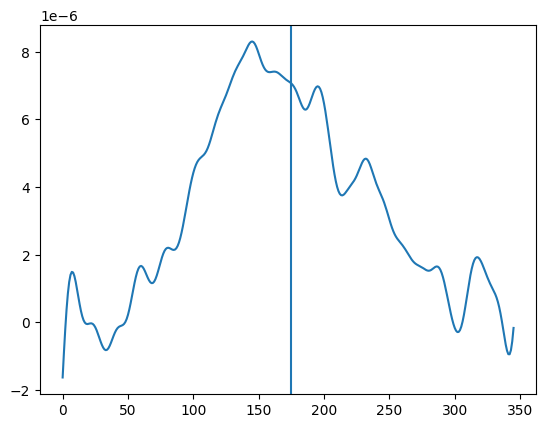

In [485]:
plt.plot(a)
plt.axvline(x=175)

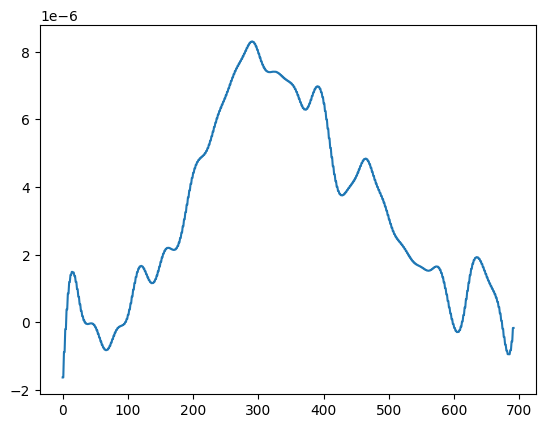

In [486]:
plt.plot(b)
